In [59]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline

#LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#Training Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler, StandardScaler

#Save & Load Model
import pickle

In [60]:
#loading of data
HDB_Full_Constructed = pd.read_csv("DataProject/flats-constructed-by-housing-and-development-board-annual.csv")
HDB_Full_Constructed.head(5)

,year,flats_constructed
0,1977,30498
1,1978,29742
2,1979,26709
3,1980,18421
4,1981,15381


In [61]:
#loading of data
HDB_Full_Number_Sold_Rent = pd.read_csv("DataProject/number-of-sold-and-rented-residential-units.csv")
HDB_Full_Number_Sold_Rent.head(5)

,financial_year,property_type,sold_or_rented,flat_type,no_of_units
0,2006,HDB,sold,1-room flats,0
1,2006,HDB,sold,2-room flats,101
2,2006,HDB,sold,3-room flats,961
3,2006,HDB,sold,4-room flats,2290
4,2006,HDB,sold,5-room flats,1303


In [62]:
#loading of data
HDB_Resale_1990_1999 = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-approval-date-1990-1999.csv")
HDB_Resale_2000Feb_2012 = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
HDB_Resale_2012Mar_2014Dec = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
HDB_Resale_2015_2018Dec = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv")

In [63]:
#Reasons of not using 1990 - 1999 and 2000 - 2012 is because alot of things has changed then, so pricing on diff area 
#might change drasticly so to prevent such data to affect the model I decided to remove it
Full_Resale_HDB_List =  [HDB_Resale_1990_1999,HDB_Resale_2000Feb_2012,HDB_Resale_2012Mar_2014Dec, HDB_Resale_2015_2018Dec]
Full_Resale_HDB = pd.concat(Full_Resale_HDB_List, ignore_index=True)

Full_Resale_HDB.tail(5)

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
789093,760,Improved,5 ROOM,122.0,1987,2018-12,67.0,470000.0,10 TO 12,YISHUN ST 72,YISHUN
789094,816,Improved,5 ROOM,122.0,1988,2018-12,68.0,500000.0,04 TO 06,YISHUN ST 81,YISHUN
789095,844,Improved,5 ROOM,127.0,1988,2018-12,69.0,500000.0,10 TO 12,YISHUN ST 81,YISHUN
789096,665,Apartment,EXECUTIVE,164.0,1992,2018-12,72.0,708000.0,07 TO 09,YISHUN AVE 4,YISHUN
789097,326,Maisonette,EXECUTIVE,146.0,1988,2018-12,68.0,560000.0,10 TO 12,YISHUN RING RD,YISHUN


In [64]:
print(Full_Resale_HDB.info())
print(Full_Resale_HDB.shape)
#Full_Resale_HDB['remaining_lease'].isna().count()

Full_Resale_HDB['remaining_lease'] = Full_Resale_HDB['remaining_lease'].fillna(999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789098 entries, 0 to 789097
Data columns (total 11 columns):
block                  789098 non-null object
flat_model             789098 non-null object
flat_type              789098 non-null object
floor_area_sqm         789098 non-null float64
lease_commence_date    789098 non-null int64
month                  789098 non-null object
remaining_lease        79100 non-null float64
resale_price           789098 non-null float64
storey_range           789098 non-null object
street_name            789098 non-null object
town                   789098 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 66.2+ MB
None
(789098, 11)


In [65]:
print(Full_Resale_HDB.info())
print(Full_Resale_HDB.shape)
Full_Resale_HDB.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789098 entries, 0 to 789097
Data columns (total 11 columns):
block                  789098 non-null object
flat_model             789098 non-null object
flat_type              789098 non-null object
floor_area_sqm         789098 non-null float64
lease_commence_date    789098 non-null int64
month                  789098 non-null object
remaining_lease        789098 non-null float64
resale_price           789098 non-null float64
storey_range           789098 non-null object
street_name            789098 non-null object
town                   789098 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 66.2+ MB
None
(789098, 11)


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
0,309,IMPROVED,1 ROOM,31.0,1977,1990-01,999.0,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO
1,309,IMPROVED,1 ROOM,31.0,1977,1990-01,999.0,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO
2,309,IMPROVED,1 ROOM,31.0,1977,1990-01,999.0,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO
3,309,IMPROVED,1 ROOM,31.0,1977,1990-01,999.0,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO
4,216,NEW GENERATION,3 ROOM,73.0,1976,1990-01,999.0,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO


In [66]:
#how many towns are there and how many flat type
print(Full_Resale_HDB['town'].unique())
print(Full_Resale_HDB['flat_type'].unique())
print(Full_Resale_HDB['month'].unique())

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT TIMAH'
 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG' 'HOUGANG'
 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'QUEENSTOWN' 'SENGKANG' 'SERANGOON' 'TAMPINES' 'TOA PAYOH' 'WOODLANDS'
 'YISHUN' 'LIM CHU KANG' 'SEMBAWANG' 'BUKIT PANJANG' 'PASIR RIS' 'PUNGGOL']
['1 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE'
 'MULTI GENERATION' 'MULTI-GENERATION']
['1990-01' '1990-02' '1990-03' '1990-04' '1990-05' '1990-06' '1990-07'
 '1990-08' '1990-09' '1990-10' '1990-11' '1990-12' '1991-01' '1991-02'
 '1991-03' '1991-04' '1991-05' '1991-06' '1991-07' '1991-08' '1991-09'
 '1991-10' '1991-11' '1991-12' '1992-01' '1992-02' '1992-03' '1992-04'
 '1992-05' '1992-06' '1992-07' '1992-08' '1992-09' '1992-10' '1992-11'
 '1992-12' '1993-01' '1993-02' '1993-03' '1993-04' '1993-05' '1993-06'
 '1993-07' '1993-08' '1993-09' '1993-10' '1993-11' '1993-12' '1994-01'
 '1994-02' '1994-03' '1994-04' '1994-05' '1994-06' '1994-0

In [67]:
Full_Resale_HDB['flat_type'].loc[Full_Resale_HDB['flat_type']=='MULTI-GENERATION'] = 'MULTI GENERATION'
print(Full_Resale_HDB['town'].unique())
print(Full_Resale_HDB['flat_type'].unique())


['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT TIMAH'
 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG' 'HOUGANG'
 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'QUEENSTOWN' 'SENGKANG' 'SERANGOON' 'TAMPINES' 'TOA PAYOH' 'WOODLANDS'
 'YISHUN' 'LIM CHU KANG' 'SEMBAWANG' 'BUKIT PANJANG' 'PASIR RIS' 'PUNGGOL']
['1 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE'
 'MULTI GENERATION']


D:\Users\Ocean\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [68]:
#Droplist Column 
droplist_train = ['block', 'lease_commence_date', 'remaining_lease', 'storey_range', 'street_name','floor_area_sqm','flat_model']
Full_Resale_HDB_train = Full_Resale_HDB.copy().drop(droplist_train, axis = 1)
Full_Resale_HDB_train.head(5)

,flat_type,month,resale_price,town
0,1 ROOM,1990-01,9000.0,ANG MO KIO
1,1 ROOM,1990-01,6000.0,ANG MO KIO
2,1 ROOM,1990-01,8000.0,ANG MO KIO
3,1 ROOM,1990-01,6000.0,ANG MO KIO
4,3 ROOM,1990-01,47200.0,ANG MO KIO


In [69]:
Full_Resale_HDB_train['month'] = Full_Resale_HDB_train['month'].str.slice(stop=4)
Full_Resale_HDB_train.head(5)

,flat_type,month,resale_price,town
0,1 ROOM,1990,9000.0,ANG MO KIO
1,1 ROOM,1990,6000.0,ANG MO KIO
2,1 ROOM,1990,8000.0,ANG MO KIO
3,1 ROOM,1990,6000.0,ANG MO KIO
4,3 ROOM,1990,47200.0,ANG MO KIO


In [70]:
Full_Resale_HDB_graph = Full_Resale_HDB_train.copy()
Full_Resale_HDB_graph['town'] = le.fit_transform(Full_Resale_HDB_graph['town'])
Full_Resale_HDB_graph['flat_type'] = le.fit_transform(Full_Resale_HDB_graph['flat_type'])
Full_Resale_HDB_graph['month'] = Full_Resale_HDB_graph['month'].astype(int)
Full_Resale_HDB_graph.head(5)

,flat_type,month,resale_price,town
0,0,1990,9000.0,0
1,0,1990,6000.0,0
2,0,1990,8000.0,0
3,0,1990,6000.0,0
4,2,1990,47200.0,0


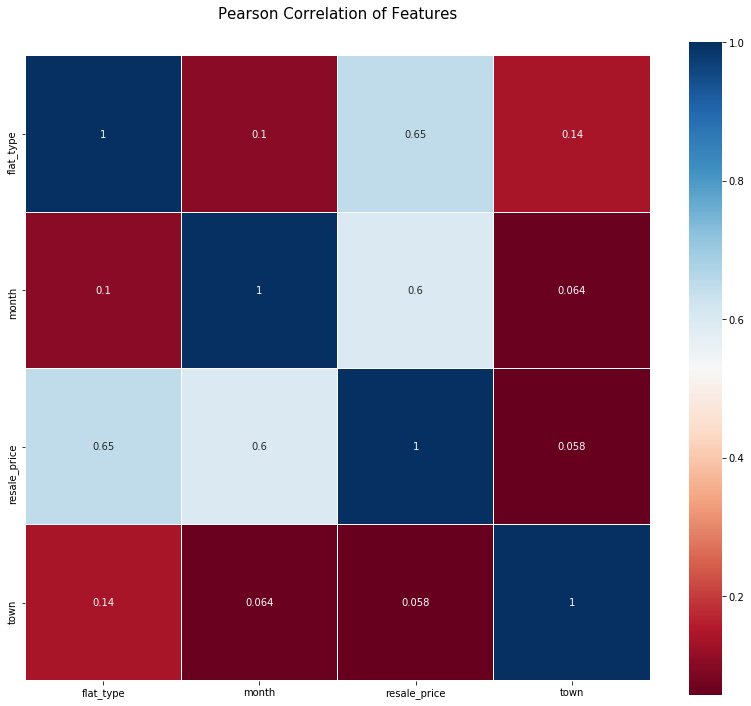

In [71]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Full_Resale_HDB_graph.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [72]:
# town seems like it doesn't really affect the resale_price if we do it this way, how about we dummies it?

In [73]:
Full_Resale_HDB_train = pd.get_dummies(Full_Resale_HDB_train, columns=['town'])
Full_Resale_HDB_train['flat_type'] = le.fit_transform(Full_Resale_HDB_train['flat_type'])
Full_Resale_HDB_train['month'] = Full_Resale_HDB_train['month'].astype(int)
Full_Resale_HDB_train.head(5)

,flat_type,month,resale_price,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,0,1990,9000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1990,6000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1990,8000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1990,6000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1990,47200.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1 ROOM = 0

2 ROOM = 1

3 ROOM = 2

4 ROOM = 3

5 ROOM = 4

EXECUTIVE = 5

MULTI GENERATION = 6

In [74]:
# find correlation of features with output
results = Full_Resale_HDB_train.corr()
#results.sort_values?
results['resale_price'].sort_values(ascending=False)
# negative values do not mean not correlated. 

resale_price            1.000000
flat_type               0.650115
month                   0.597768
town_PASIR RIS          0.129094
town_SENGKANG           0.122667
town_PUNGGOL            0.115439
town_BISHAN             0.109730
town_SEMBAWANG          0.048805
town_TAMPINES           0.048769
town_CHOA CHU KANG      0.046863
town_BUKIT TIMAH        0.044101
town_BUKIT MERAH        0.026052
town_MARINE PARADE      0.019027
town_SERANGOON          0.017959
town_BUKIT PANJANG      0.013643
town_HOUGANG            0.004274
town_WOODLANDS         -0.000254
town_CENTRAL AREA      -0.001963
town_KALLANG/WHAMPOA   -0.007265
town_LIM CHU KANG      -0.013830
town_TOA PAYOH         -0.018861
town_JURONG EAST       -0.031013
town_JURONG WEST       -0.032459
town_CLEMENTI          -0.042073
town_QUEENSTOWN        -0.046288
town_GEYLANG           -0.051443
town_BUKIT BATOK       -0.055814
town_BEDOK             -0.067299
town_YISHUN            -0.085549
town_ANG MO KIO        -0.091853
Name: resa

It seems like the Town do affect resale_price after we dummies it.

# Train Model

In [75]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()

In [76]:
def train_model_UserInput_flat_type_month_resale_price_town (model, X_train,X_test_,y_train,y_test):
    model = model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cv_scores_train = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    cv_scores_test = -cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=10)
    print('Train RSME: {:.5f} | Test RSME: {:.5f} | R^2: {:.5f}'.format(np.sqrt(cv_scores_train).mean(), np.sqrt(cv_scores_test).mean(), r2_score(y_test, y_pred)))

In [121]:
y = Full_Resale_HDB_train['resale_price']
y.head(5)

0     9000.0
1     6000.0
2     8000.0
3     6000.0
4    47200.0
Name: resale_price, dtype: float64

In [168]:
Full_Resale_HDB_train_dropResale = Full_Resale_HDB_train.copy().drop('resale_price',axis=1)
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = \
    train_test_split(Full_Resale_HDB_train_dropResale.copy(), y, test_size=0.3, random_state=42)

print('Shapes')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

Shapes
X_train: (552368, 29)
X_test: (236730, 29)
y_train: (552368,)
y_test: (236730,)


In [169]:
X_train.head(5)

,flat_type,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
531300,4,2007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
587396,4,2009,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
644230,2,2011,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331554,4,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
94649,2,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
#let the model understand what is the data [OneHotEncoder]
onehotencoder = OneHotEncoder(categorical_features = [0])
X_train = onehotencoder.fit_transform(X_train).toarray()
X_test = onehotencoder.fit_transform(X_test).toarray()

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 2.007e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [171]:
X_train.shape

(552368, 35)

In [172]:
regressor = LinearRegression()
train_model_UserInput_flat_type_month_resale_price_town(regressor, X_train,X_test,y_train,y_test)

Train RSME: 70911.76805 | Test RSME: 70885.41889 | R^2: 0.76083


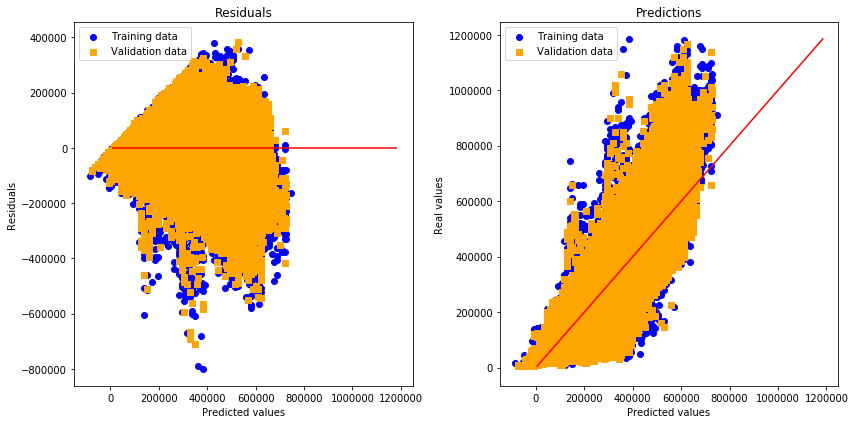

In [173]:
model_evaluation_plots(regressor, X_train, y_train, X_test, y_test)

In [174]:
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

train_model_UserInput_flat_type_month_resale_price_town(ridge, X_train,X_test,y_train,y_test)

Train RSME: 70911.84116 | Test RSME: 70885.20984 | R^2: 0.76083


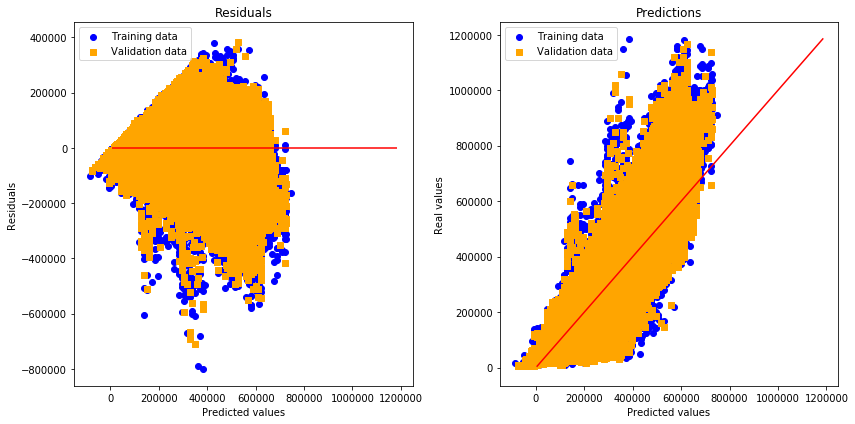

In [175]:
model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

from sklearn.linear_model import Lasso

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

train_model_UserInput_flat_type_month_resale_price_town(lasso, X_train,X_test,y_train,y_test)

# Very Slow run it for 1h still havent finish training

i cant use other model cuz mostly it is very slow so i decided to go with ridge cuz is better then regressor by abit but it is still slow in running

In [176]:

filename = 'regressor_model.p'
pickle.dump(regressor, open(filename, 'wb'))

filename = 'ridge_model.p'
pickle.dump(ridge, open(filename, 'wb'))

In [177]:
#check if model works anot
regressor2 = pickle.load( open( "regressor_model.p", "rb" ) )
print(regressor2.predict(X_test))

ridge2 = pickle.load( open( "ridge_model.p", "rb" ) )
print(ridge2.predict(X_test))

[501283.25   427870.25   342749.25   ... 166996.0625 204390.9375
 399157.875 ]
[501293.35269488 427968.77718523 342729.94091681 ... 166988.70991846
 204384.17104318 399139.78967843]


In [178]:
def flat_type_numerical(x):
    return {
        '1 ROOM': 0,
        '2 ROOM': 1,
        '3 ROOM': 2,
        '4 ROOM': 3,
        '5 ROOM': 4,
        'EXECUTIVE': 5,
        'MULTI GENERATION': 6
    }[x]

In [179]:
#function to predict
input_columns = list(Full_Resale_HDB_train.columns.values)
input_columns.remove('resale_price')
input_row = np.zeros(shape=(1,29))
input_data = pd.DataFrame(input_row,columns=input_columns)

# flat_type = input('flat_type:').upper()
# town = input('town:').upper()
# year = input('year:')
flat_type = '1 ROOM'.upper()
town = 'ang mo kio'.upper()
year = '2019'
input_data['flat_type'] = flat_type_numerical(flat_type)
input_data['town_' + town] = 1
input_data['month'] = int(year)
input_data
#API for Hooking Bluemix


,flat_type,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
input_columns_town = list(Full_Resale_HDB_train.columns.values)
input_columns_town.remove('flat_type')
input_columns_town.remove('month')
input_columns_town.remove('resale_price')

for town_column in input_columns_town:
    input_data[town_column] = input_data[town_column].astype(np.uint8)
input_data['month'] = input_data['month'].astype(np.int32)
input_data


,flat_type,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,0,2019,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 29 columns):
flat_type               1 non-null int64
month                   1 non-null int32
town_ANG MO KIO         1 non-null uint8
town_BEDOK              1 non-null uint8
town_BISHAN             1 non-null uint8
town_BUKIT BATOK        1 non-null uint8
town_BUKIT MERAH        1 non-null uint8
town_BUKIT PANJANG      1 non-null uint8
town_BUKIT TIMAH        1 non-null uint8
town_CENTRAL AREA       1 non-null uint8
town_CHOA CHU KANG      1 non-null uint8
town_CLEMENTI           1 non-null uint8
town_GEYLANG            1 non-null uint8
town_HOUGANG            1 non-null uint8
town_JURONG EAST        1 non-null uint8
town_JURONG WEST        1 non-null uint8
town_KALLANG/WHAMPOA    1 non-null uint8
town_LIM CHU KANG       1 non-null uint8
town_MARINE PARADE      1 non-null uint8
town_PASIR RIS          1 non-null uint8
town_PUNGGOL            1 non-null uint8
town_QUEENSTOWN         1 non-null uin

In [182]:
input_data = onehotencoder.transform(input_data)

input_data.shape

(1, 35)

In [183]:
print(ridge2.predict(input_data))

[247934.39675879]
